# Solving the diffusion equation with DifferentialEquations.jl

## Problem Description
The problem is defined as following:
$$\frac{\partial u}{\partial t} - \nabla \cdot (k \nabla u) = f, (x,y) \in \Omega, t \in (0,T]$$
$$ u(x,y,t)=0, (x,y) \in \partial \Omega $$
$$u(x, y, 0) = 0, (x, y) \in Ω $$

$$f(x, y) = e^{-\alpha(x - x_1)^2 - \alpha(y - y_1)^2} + e^{-\alpha(x - x_2)^2 - \alpha(y - y_2)^2} + e^{-\alpha(x - x_3)^2 - \alpha(y - y_3)^2} + e^{-\alpha(x - x_4)^2 - \alpha(y - y_4)^2}$$
$$k(x, y) =
\begin{cases}
0.1 & \text{if } x < \frac{Lx}{2}, y < \frac{Ly}{2} \\
0.4 & \text{if } x < \frac{Lx}{2}, y \geq \frac{Ly}{2} \\
0.7 & \text{if } x \geq \frac{Lx}{2}, y \geq \frac{Ly}{2} \\
1.0 & \text{if } x \geq \frac{Lx}{2}, y < \frac{Ly}{2}
\end{cases}$$


Parameters:
$$Lx = 10 $$
$$Ly = 5 $$
$$α = 40 $$
$$(x₁, y₁) = (0.25 * Lx, 0.25 * Ly) $$
$$(x₂, y₂) = (0.25 * Lx, 0.75 * Ly) $$
$$(x₃, y₃) = (0.75 * Lx, 0.75 * Ly) $$
$$(x₄, y₄) = (0.75 * Lx, 0.25 * Ly) $$

We will first import some packages and define some global variables.

In [2]:
using LinearAlgebra
using SparseArrays
using Plots
using DifferentialEquations

false

In [9]:
Nx = 200 
Ny = 100
LeftX = 0
LeftY = 0
RightX = 10
RightY = 5
hx = (RightX - LeftX)/Nx 
hy = (RightY - LeftY)/Ny 
tStart = 0
tEnd = 1
Nt = tEnd*1600
ht = (tEnd - tStart)/Nt
write_csv = false

false

## Spatial discretization

In [3]:
x_points = [j for j in LeftX:hx:RightX][2:end-1]
y_points = [i for i in LeftY:hy:RightY][2:end-1]

x = zeros((Ny-1, Nx-1))
y = zeros((Ny-1, Nx-1))

for j in 1:length(y_points)
    x[j, :] = x_points
end

for i in 1:length(x_points)
    y[:, i] = y_points
end


Implementation of the source function and coefficient function:

In [4]:

function sourcefunc(x, y, RightX, RightY)
    f = exp.(-40.0 * (x .- 0.25 * RightX) .^ 2 .- 40.0 * (y .- 0.25 * RightY) .^ 2) +
    exp.(-40.0 * (x .- 0.25 * RightX) .^ 2 .- 40.0 * (y .- 0.75 * RightY) .^ 2) +
    exp.(-40.0 * (x .- 0.75 * RightX) .^ 2 .- 40.0 * (y .- 0.75 * RightY) .^ 2) +
    exp.(-40.0 * (x .- 0.75 * RightX) .^ 2 .- 40.0 * (y .- 0.25 * RightY) .^ 2)
return f
end

function coeffK(x, y)
if !(x isa Array)
    if x<(RightX/2) && y<(RightY/2)
        return 0.1
    elseif x<(RightX/2) && y>=(RightY/2)
        return 0.4
    elseif x>=(RightX/2) && y>=(RightY/2)
        return 0.7
    else
        return 1.0
    end
else
    result = zeros(size(x))
    line_x = findall(x.<(RightX/2))[end][2]
    line_y = findall(y.<(RightY/2))[end][1]
    result[1:line_y, 1:line_x] .= 0.1
    result[line_y+1:end, 1:line_x] .= 0.4
    result[line_y+1:end, line_x+1:end] .= 0.7
    result[1:line_y, line_x+1:end] .= 1.0
end
return result
end

coeffK (generic function with 1 method)

Create LaPlacian matrix:

In [5]:
function create2DLFVM(Nx, hx, hy, x, y, coeffFun)
    main_arr = ((1 / (hx * hx)) .* (coeffFun(x .- 0.5 * hx, y) .+ coeffFun(x .+ 0.5 * hx, y)) .+ (1 / (hy * hy)) .* (coeffFun(x, y .- 0.5 * hy) .+ coeffFun(x, y .+ 0.5 * hy)))
    main_arr = vec(main_arr')
    k3_arr = -(coeffFun(x, y .+ 0.5 * hy)) ./ (hy * hy)
    k3_arr = vec(k3_arr')
    k3_arr = k3_arr[1:(end - Nx + 1)]
    k1_arr = -(coeffFun(x .+ 0.5 * hx, y)) ./ (hx * hx)
    k1_arr[:, end] .= 0
    k1_arr = vec(k1_arr')
    k1_arr = k1_arr[1:(end - 1)]
    A = SparseArrays.spdiagm(0 => main_arr, -1 => k1_arr, 1 => k1_arr, (-Nx+1) => k3_arr, (Nx-1) => k3_arr)
    return A
end

create2DLFVM (generic function with 1 method)

##  Temporal discretization
Define some sourses needed to solve the right-hand-side function:

In [6]:
f = sourcefunc(x, y, RightX, RightY)
fLX = vec(f')
A = create2DLFVM(Nx, hx, hy, x, y, coeffK)
uStart = zeros((Nx-1)*(Ny-1), 1)
# println("Created the system, moving on to the time integration...")

19701×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Define the right-hand-side function, ODE problem and solve:

In [13]:
RHS(du, u, p, t) = du .= -A * u .+ fLX
u0 = uStart
tspan = (tStart, tEnd)
problem = ODEProblem(RHS, u0, tspan)
solution = solve(problem, Euler(), dt = ht, save_everystep = false) # The ODE solver can be defined here, I chose Forward Euler Method with a fixed time step here. If no algorithm is given, a defult one will be chosen.
uEnd = solution.u[end]
uEnd1 = reshape(uEnd, Nx-1, Ny-1)'

99×199 adjoint(::Matrix{Float64}) with eltype Float64:
 3.59806e-11  8.37987e-11  1.58651e-10  …  1.11594e-5   5.56243e-6
 7.41099e-11  1.72614e-10  3.26834e-10     2.22877e-5   1.11093e-5
 1.16528e-10  2.71445e-10  5.14049e-10     3.33539e-5   1.66253e-5
 1.65353e-10  3.85236e-10  7.29699e-10     4.43272e-5   2.20949e-5
 2.22652e-10  5.18819e-10  9.82978e-10     5.51768e-5   2.75028e-5
 2.904e-10    6.76811e-10  1.28268e-9   …  6.58725e-5   3.28339e-5
 3.70413e-10  8.63465e-10  1.6369e-9       7.63841e-5   3.80732e-5
 4.64271e-10  1.08248e-9   2.05272e-9      8.66822e-5   4.3206e-5
 5.73213e-10  1.33676e-9   2.53569e-9      9.67379e-5   4.8218e-5
 6.98023e-10  1.62815e-9   3.08935e-9      0.000106523  5.30951e-5
 ⋮                                      ⋱               
 1.33386e-5   2.70336e-5   4.14469e-5   …  7.70606e-5   3.83325e-5
 1.19369e-5   2.4192e-5    3.70882e-5      6.90621e-5   3.4354e-5
 1.05048e-5   2.1289e-5    3.2636e-5       6.08654e-5   3.02769e-5
 9.0473e-6    1.8334

## Visualizing the results

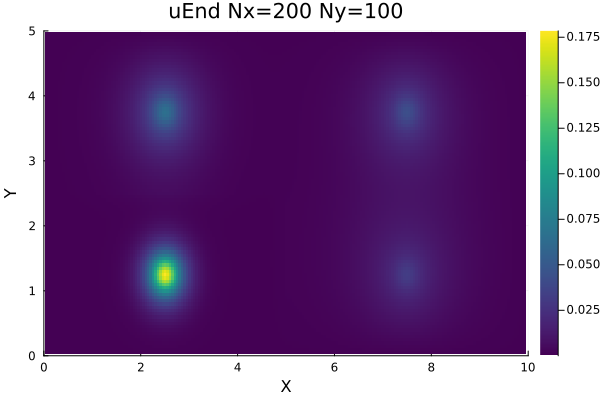

In [11]:
if write_csv
    using DataFrames, CSV
    df = DataFrame(uEnd, :auto)
    CSV.write("uEnd_DE.csv", df)
    println("Solution written to uEnd_DE.csv")
end

heatmap(x_points, y_points, uEnd, xlim=(LeftX, RightX), ylim=(LeftY, RightY), origin=:lower, c=:viridis, xlabel="X", ylabel="Y", title="uEnd Nx=$Nx Ny=$Ny", colorbar=true)